In [1]:
%matplotlib inline
import numpy as np
import torch
import math
import sys
from torch import optim
import matplotlib.pyplot as plt
from IPython import display
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def use_svg_display():
# 用矢量图显示。
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    display.set_matplotlib_formats('svg')
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def train_2d(trainer, epioc=10):  
    x1, x2, s1, s2 = -5, -2, 0, 0  # s1和s2是自变量状态，本章后续几节会使用
    results = [(x1, x2)]
    for i in range(epioc):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):  
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 2.0, 0.1), np.arange(-3.0, 1.5, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

### 局部最小值

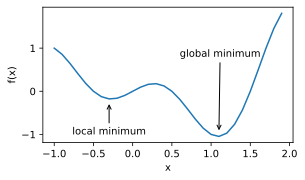

In [3]:
def f(x):
    return x * np.cos(np.pi * x)

set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig,  = plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

### 鞍点

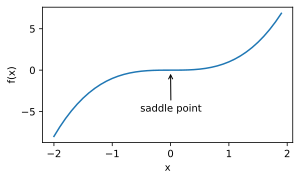

In [4]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

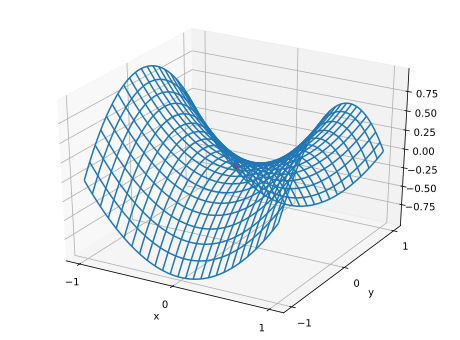

In [5]:
x, y = np.mgrid[-1: 1: 100j, -1: 1: 100j]
z = x**2 - y**2

ax = plt.figure(figsize=(8,6)).add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 4, 'cstride': 5})
ax.plot([0], [0], [0], 'ro-')
ticks = [-1,  0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
# ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y');

### 梯度下降

#### 一维梯度下降

In [6]:
def gd(x, eta):
    
    results = [x]
    for i in range(10):
        x -= eta * 2 * x  # f(x) = x * x的导数为f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(20, 0.2)

epoch 10, x: 0.12093235199999994


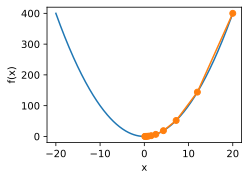

In [7]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    set_figsize()
    plt.plot(f_line, [x * x for x in f_line])
    plt.plot(res, [x * x for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('f(x)')

show_trace(res)

epoch 10, x: 6.973568801999999


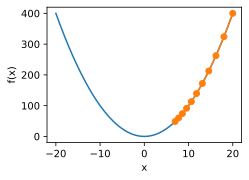

In [8]:
show_trace(gd(20, 0.05))

epoch 10, x: 123.83472844800019


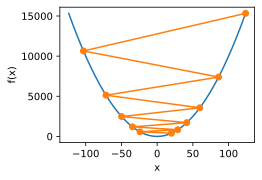

In [9]:
show_trace(gd(20, 1.1))

### 多维梯度下降
多维函数$f(x) = x_1^2+2x_2^2$
<br>梯度$\nabla f(\boldsymbol{x}) = [2x_1, 4x_2]^\top$

观察梯度下降从初始位置$[-5,-2]$开始对自变量$\boldsymbol{x}$的迭代轨迹

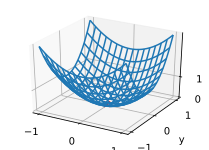

In [10]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 + 2*y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y');

epoch 10, x1 -0.536871, x2 -0.012093


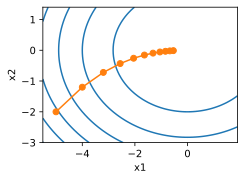

In [11]:
def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

eta = 0.1 # 学习率为0.1

show_trace_2d(f_2d, train_2d(gd_2d))

epoch 10, x1 -0.000001, x2 -0.012093


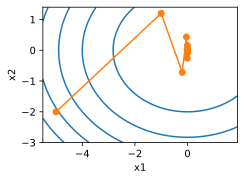

In [12]:
eta = 0.4 # 学习率为0.4

show_trace_2d(f_2d, train_2d(gd_2d))

epoch 10, x1 -0.000000, x2 -2.960489


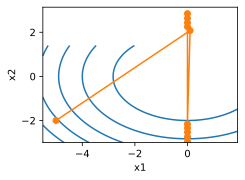

In [13]:
eta = 0.51

show_trace_2d(f_2d, train_2d(gd_2d))

### 随机梯度下降SGD

epoch 10, x1 -0.501580, x2 0.061699


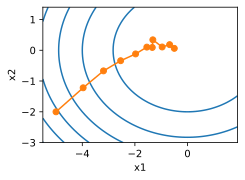

In [14]:
eta = 0.1

def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0)),
            x2 - eta * (4 * x2 + np.random.normal(0)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

### 小批量随机梯度下降

使用NASA的测试不同飞机机翼噪音的数据集来比较各个优化算法。我们使用该数据集的前1,500个样本和5个特征，并使用标准化对数据进行预处理。

In [15]:
features, labels = d2l.get_data_ch7()
features

NameError: name 'd2l' is not defined

In [ ]:
features.shape

In [ ]:
# 梯度下降
train_pytorch_ch7(optim.SGD, {"lr": 0.9}, features, labels, 1500, 6)

In [ ]:
# 随机梯度下降
train_pytorch_ch7(optim.SGD, {"lr": 0.005}, features, labels, 1)

In [ ]:
# 小批量随机梯度下降  批量大小为10
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)

### 梯度下降的问题

$$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$$

实现基于这个目标函数的梯度下降

In [ ]:
eta = 0.2 # 学习率

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d, 20))

In [ ]:
eta = 0.4 # 学习率

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d, 10))

In [ ]:
eta = 0.52
show_trace_2d(f_2d, train_2d(gd_2d, 20))

学习率越过目标函数最优解后，竖直方向（$x_2$轴方向）逐渐发散

目标函数在竖直方向（$x_2$轴方向）比在水平方向（$x_1$轴方向）的斜率的绝对值更大<br>
我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。
<br><br>另一个看待问题的角度是，在纵轴上，你希望学习慢一点，因为你不想要这些摆动，但是在横轴上，你希望加快学习，你希望快速从左向右移，移向最小值，移向红点。

### 动量法
$$
\begin{aligned}
\boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t,
\end{aligned}
$$

其中，动量超参数$\gamma$满足$0 \leq \gamma < 1$。当$\gamma=0$时，动量法等价于小批量随机梯度下降。

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d, 20))

In [ ]:
# 使用较大的学习率eta=0.6，自变量也不再发散
eta = 0.25
show_trace_2d(f_2d, train_2d(momentum_2d, 20))

In [ ]:
# 使用较大的学习率eta=0.6，自变量也不再发散
eta = 0.6
show_trace_2d(f_2d, train_2d(momentum_2d))

In [ ]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.02, 'momentum': 0.5},
                    features, labels)

In [ ]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.02, 'momentum': 0.9},
                    features, labels)

In [ ]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)

### Nesterov Momentum

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + (1 - gamma) * 0.2 * (x1 - eta * gamma * v1)
    v2 = gamma * v2 + (1 - gamma) * 4 * (x2 - eta * gamma *v2)
    return x1 - eta * v1, x2 - eta * v2, v1, v2

gamma, eta = 0.4, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d, 20))

In [ ]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.02, 'momentum': 0.5, 'nesterov': True},
                    features, labels)

### AdaGrad
$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

In [ ]:
def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d, 20))

In [ ]:
eta = 1.5
show_trace_2d(f_2d, train_2d(adagrad_2d))

In [ ]:
# 简洁实现
train_pytorch_ch7(torch.optim.Adagrad, {'lr': 0.1}, features, labels)

### RMSProp
$$\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t$$
$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t $$

In [ ]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

In [ ]:
train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9},
                    features, labels)

### Adam

In [ ]:
def adam_2d(x1, x2, v1, v2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-8
    v1 = gamma_v * v1 + (1 - gamma_v) * g1
    v2 = gamma_v * v2 + (1 - gamma_v) * g2
    s1 = gamma_s * s1 + (1 - gamma_s) * g1 ** 2
    s2 = gamma_s * s2 + (1 - gamma_s) * g2 ** 2
    x1 -= eta * v1 / (math.sqrt(s1) + eps)
    x2 -= eta * v2 / (math.sqrt(s2) + eps)
    return x1, x2, v1, v2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma_v, gamma_s = 0.1, 0.9, 0.999
show_trace_2d(f_2d, train_adam_2d(adam_2d, 40))

In [ ]:
def train_adam_2d(trainer, epioc=10):
    x1, x2, v1, v2, s1, s2 = -5, -2, 0, 0, 0, 0
    results = [(x1, x2)]
    for i in range(epioc):
        x1, x2, v1, v2, s1, s2 = trainer(x1, x2, v1, v2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

In [ ]:
train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)